# 감성 분류

- 분류 모델의 가장 대표적인 활용 방법 중 하나
- 텍스트 데이터를 긍정 또는 부정으로 나누어 분류하는 것 

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from konlpy.tag import Okt

In [104]:
okt.morphs("집에가고싶당")

['집', '에', '가고싶당']

<img src = "./image/형태소분석기비교_만.png">

- komoran 은 느리고 형태소 분석은 잘해주지만 프로그램화하기가 문제가 많음 
- 데이터를 10000개 정도 수집한 다음에 okt 가지고 형태소 분석돌리면 결과물 보기까지 20분정도 걸림 
- mecab은 거의 바로 됨 
- 윈도우는 mecab 못씀 

# 맛집 상세페이지 url 정보 크롤링 

In [107]:
# 크롤링할 주소
url = "https://map.kakao.com/"

In [108]:
# from selenium import webdriver
# # from selenium.webdriver.chrome.service import Service as ChromeService
# from webdriver_manager.chrome import ChromeDriverManager

# driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

In [109]:
# driver = webdriver.Chrome()
driver = webdriver.Chrome(ChromeDriverManager().install())

# 카카오지도 접속
driver.get(url)

# 검색창에 검색어 입력 
searchbox = driver.find_element(By.CSS_SELECTOR, "input.query")
searchbox.send_keys("신촌 맛집")

# 엔터 눌러서 결과 받아오기
searchbox.send_keys(Keys.ENTER)

# 검색 결과를 가져올 시간 대기 
time.sleep(1)

# html 정보 파싱 
soup = BeautifulSoup(driver.page_source, "lxml")
moreviews = soup.select("a.moreview")

# 크롤링할 페이지 리스트 생성 
page_urls = []

for more in moreviews:
    page = more.get("href")
    page_urls.append(page)
    
driver.close()

In [110]:
page_urls

['https://place.map.kakao.com/1165755646',
 'https://place.map.kakao.com/15937430',
 'https://place.map.kakao.com/27144649',
 'https://place.map.kakao.com/1011256721',
 'https://place.map.kakao.com/26976526',
 'https://place.map.kakao.com/26522526',
 'https://place.map.kakao.com/7892863',
 'https://place.map.kakao.com/17505297',
 'https://place.map.kakao.com/18826661',
 'https://place.map.kakao.com/1705674698',
 'https://place.map.kakao.com/15847929',
 'https://place.map.kakao.com/10621045',
 'https://place.map.kakao.com/1227036908',
 'https://place.map.kakao.com/10386326',
 'https://place.map.kakao.com/12502450']

# 상세페이지에서 리뷰 크롤링 

In [111]:
res = requests.get("https://place.map.kakao.com/commentlist/v/1165755646/")

In [112]:
data = res.json()

In [113]:
# 별점
data["comment"]["list"][0]["point"]

4

In [114]:
# 댓글
data["comment"]["list"][0]["contents"]

'마늘바게트 맛있지만 너무 달아서 아쉬웠어요'

In [115]:
# 한번 더보기를 할 때 마다 5개씩 들어옴 
len(data["comment"]["list"])

5

In [116]:
# 마지막 댓글 id 까지 받아옴
data["comment"]["list"][-1]["commentid"]

'9744583'

In [117]:
stars = []
reviews = []

# 댓글 정보 url # 맨끝 숫자는 가게아이디 비워둘것임 (1165755646)
base_url = "https://place.map.kakao.com/commentlist/v/"

# 위에서 수집한 15개 가게에 대해서 수집
# page_urls : 상세보기 페이지 -> 제일 뒷번호 : 가게 id
for url in page_urls:
    last_id = ""
    
    # 5번 더보기 수행 
    for _ in range(5):
        res = requests.get(base_url + url[28:] + "/" + last_id)
        data = res.json()
        
        # 별점, 리뷰 수집 
        for review in data["comment"]["list"]:
            stars.append(review["point"])
            reviews.append(review.get("contents", ""))
            
        # 더보기 시에 사용할 마지막 id 
        last_id = review["commentid"]
        time.sleep(1)

In [118]:
len(reviews)

375

In [119]:
# 로지스틱 분류에 사용되는 녀석
df = pd.DataFrame({"score" : stars, "review" : reviews})

In [120]:
df.head()

,score,review
0,4,마늘바게트 맛있지만 너무 달아서 아쉬웠어요
1,5,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네
2,5,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 \n저녁에 방문했는데도 마늘바게트는 충분했습니다...
3,5,"현재 기준, 맛으로 종합 1위 인정합니다. 다만, 마늘 바게트가 다른 곳보다 맛있지..."
4,5,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛


In [121]:
# 5,4점이 제일 많고 2점이 젤 적음 (긍정)
# 1,2 가 부정 
df["score"].value_counts()

score
5    152
4     89
3     57
1     51
2     26
Name: count, dtype: int64

In [122]:
# 4점 이상 리뷰는 긍정 리뷰, 3점 이하는 부정 리뷰로 평가
df["y"] = df["score"].map(lambda x: 1 if x > 3 else 0)

In [123]:
# ~3점까지 부정, 나머진 긍정 리뷰
df.head(10)

,score,review,y
0,4,마늘바게트 맛있지만 너무 달아서 아쉬웠어요,1
1,5,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네,1
2,5,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 \n저녁에 방문했는데도 마늘바게트는 충분했습니다...,1
3,5,"현재 기준, 맛으로 종합 1위 인정합니다. 다만, 마늘 바게트가 다른 곳보다 맛있지...",1
4,5,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛,1
5,5,,1
6,5,마늘바게트 이외에 다른빵도 다 맛나요!\n강릉점이랑 맛도 똑같아용,1
7,3,마늘바게트 정말 달고 기름져서 한번에 많이는 못 먹을 거 같아요! 그래도 맛있습니다,0
8,5,,1
9,5,,1


In [124]:
# 레이블값 비율 확인
df["y"].value_counts()

y
1    241
0    134
Name: count, dtype: int64

# 텍스트 전처리

## 한글 추출 
- 영어 제거하다보면 느낌표 컴마 숫자 등등 많은 것들이 제외됨 
- shift + tab : 쓴 함수 뜻 나옴 

In [125]:
# -> 뜻 반환값 
# 3중 따옴표 : 함수에 대한 설명 
def text_cleaning(text:str)-> str:
    '''
    텍스트 정제 함수.
    한글 이외의 문자는 전부 제거.
    '''
    # 한글 이외의 문자들 추출
    # re 정규 표현식 (regex) : NLP 에서 기본 
    # ㄱ ~ ㅣ 자음부터 모음까지 전부 포함 됨 
    # 한글 조합 맨처음 : 가 / 맨마지막 : 힣 (한글 자음 모합 되는 모든 경우의 수)
    # ^  얘네들을 제외한 나머지 (한글이 아닌 모든것들을 찾아냄 )
    han = re.compile("[^ ㄱ - ㅣ 가-힣]+")
    # 한글 이외의 문자들 제거 #substitute  바꿔줌 
    text = han.sub(" ", text)
    
    return text

In [126]:
text_cleaning("테스트용 텍스트 정제 잘하고 있니?????help me 1234567")

'테스트용 텍스트 정제 잘하고 있니     '

In [127]:
# korean text
df["ko_text"] = df["review"].map(text_cleaning)

In [128]:
# 전처리로 인해 비어있는 텍스트가 많아짐 
df.head()

,score,review,y,ko_text
0,4,마늘바게트 맛있지만 너무 달아서 아쉬웠어요,1,마늘바게트 맛있지만 너무 달아서 아쉬웠어요
1,5,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네,1,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네
2,5,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 \n저녁에 방문했는데도 마늘바게트는 충분했습니다...,1,마늘바게트 진짜 개 개 맛있어요 저녁에 방문했는데도 마늘바게트는 충분했습니다 좀 ...
3,5,"현재 기준, 맛으로 종합 1위 인정합니다. 다만, 마늘 바게트가 다른 곳보다 맛있지...",1,현재 기준 맛으로 종합 위 인정합니다 다만 마늘 바게트가 다른 곳보다 맛있지...
4,5,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛,1,맛있음 오픈때가야 따듯하고 진짜 존맛


In [129]:
df.shape

(375, 4)

In [130]:
# 내용이 없는 데이터 제거
# text 길이가 0을 초과하는 경우에만 살려둠 
df = df[df["ko_text"].str.len() > 0]

In [131]:
# 공백이 있는 데이터는 사라짐 
df.head(10)

,score,review,y,ko_text
0,4,마늘바게트 맛있지만 너무 달아서 아쉬웠어요,1,마늘바게트 맛있지만 너무 달아서 아쉬웠어요
1,5,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네,1,여기 밤식빵 진짜 밤 많이 들어가고 맛있는데 사진은 거의 마늘빵이네
2,5,마늘바게트 진짜 개ㅐ개ㅐㅐㅐ맛있어요 \n저녁에 방문했는데도 마늘바게트는 충분했습니다...,1,마늘바게트 진짜 개 개 맛있어요 저녁에 방문했는데도 마늘바게트는 충분했습니다 좀 ...
3,5,"현재 기준, 맛으로 종합 1위 인정합니다. 다만, 마늘 바게트가 다른 곳보다 맛있지...",1,현재 기준 맛으로 종합 위 인정합니다 다만 마늘 바게트가 다른 곳보다 맛있지...
4,5,맛있음 ㅜㅜ 오픈때가야 따듯하고 진짜 존맛,1,맛있음 오픈때가야 따듯하고 진짜 존맛
6,5,마늘바게트 이외에 다른빵도 다 맛나요!\n강릉점이랑 맛도 똑같아용,1,마늘바게트 이외에 다른빵도 다 맛나요 강릉점이랑 맛도 똑같아용
7,3,마늘바게트 정말 달고 기름져서 한번에 많이는 못 먹을 거 같아요! 그래도 맛있습니다,0,마늘바게트 정말 달고 기름져서 한번에 많이는 못 먹을 거 같아요 그래도 맛있습니다
11,5,여기서 먹은 마늘빵이 자꾸 생각나요&hellip;,1,여기서 먹은 마늘빵이 자꾸 생각나요
12,5,모든 이들의 입맛을 맞추기 어려울 수 있지만\n모든 손님에게 친절한.,1,모든 이들의 입맛을 맞추기 어려울 수 있지만 모든 손님에게 친절한
13,5,무슨 말이 필요한가요\n마늘 바게트 ..아주 그냥 도른맛입니다,1,무슨 말이 필요한가요 마늘 바게트 아주 그냥 도른맛입니다


In [132]:
# 전처리 후 297개 남음 
df.shape

(296, 4)

## 형태소 추출 

In [133]:
def get_pos(x):
    '''
    텍스트 데이터에서 형태소 추출하는 함수
    '''
    okt = Okt()
    pos = okt.pos(x)
    
    # 텍스트 정보로 가공을 함 왼쪽은 단어 
    pos = [f"{word}/{tag}" for word, tag in pos]
    
    return pos

In [134]:
okt.pos("집에 가고 싶다")

[('집', 'Noun'), ('에', 'Josa'), ('가고', 'Verb'), ('싶다', 'Verb')]

In [135]:
# 텍스트2
result = get_pos(df["ko_text"].values[0])
result

['마늘/Noun',
 '바게트/Noun',
 '맛있지만/Adjective',
 '너무/Adverb',
 '달아서/Verb',
 '아쉬웠어요/Adjective']

- 단어가 너무 많기 때문에 one-hot encoding 은 불가

## 텍스트 임베딩 

- 텍스트 데이터를 연산이 가능한 피처로 변환 

In [136]:
# 297개의 문서
df.shape

(296, 4)

### TF-IDF(Term Frequency-Inverse Document Frequency)

- 단어의 빈도와 역문서 빈도를 사용하여 각 단어들의 중요도를 가중치로 주는 방법 
- TF : 1개의 문서(문장) 내에서 특정 단어의 등장 빈도
- DF : 특정 단어가 등장한 문서 수
- IDF : DF에 반비례하는 수
- 다른 문서들에서는 많이 등장하지 않았지만 현재 문서에서는 많이 등장하는 단어를 의미
    - 해당 단어가 현재 문서에서 얼마나 중요한지를 계산하는 방법 

In [137]:
x = df["ko_text"]
y = df["y"]

In [138]:
# 실제로 서비스에 적용한다고 치면 테스트하게 되는 데이터는 TF -IDF 계산될수 없는 녀석들
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 11)

In [139]:
# 훈련 데이터 207개
len(x_train)

207

In [140]:
tfidf = TfidfVectorizer() # tfidf객체를 만들고
tf_train = tfidf.fit_transform(x_train)
tf_test = tfidf.transform(x_test)

In [141]:
tf_train.shape

(207, 2078)

In [142]:
# sparse_csr_matrix 는 눈으로 확인하기가 힘듦
type(tf_train)

scipy.sparse._csr.csr_matrix

In [143]:
# 눈으로 봐도 잘 이해가 안됨 원래그런거임 
pd.DataFrame(tf_train)

,0
0,"(0, 1276)\t0.14501477360730308\n (0, 1095)\..."
1,"(0, 1520)\t0.37237353899758824\n (0, 1474)\..."
2,"(0, 52)\t0.6699870979666271\n (0, 1492)\t0...."
3,"(0, 693)\t0.3019770276587898\n (0, 1882)\t0..."
4,"(0, 1950)\t0.7071067811865476\n (0, 853)\t0..."
...,...
202,"(0, 1541)\t0.42397360797538164\n (0, 1371)\..."
203,"(0, 1433)\t0.766586271795038\n (0, 1814)\t0..."
204,"(0, 1724)\t0.36838471434633674\n (0, 523)\t..."
205,"(0, 409)\t1.0"


- tfidf로 데이터로 잘 전환했다면 전부 다 숫자형의 데이터로 바뀜, 이제는 문제없이 모델훈련 가능 

## 모델 훈련

In [144]:
# 정답값이 부정적인지 긍정인지 
logi = LogisticRegression()
logi.fit(tf_train, y_train)

LogisticRegression()

In [145]:
# 예측치 (결정확률까지 proba)
pred = logi.predict(tf_test)
proba = logi.predict_proba(tf_test)[:, 1]

In [146]:
# 처참한 정확도 
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.5842696629213483
0.7338129496402878


In [147]:
# 혼동행렬 
comat = confusion_matrix(y_test, pred)
print(comat)

[[ 1 36]
 [ 1 51]]


In [148]:
# 1긍정
# 바선생이 보이는데도 불구하고 1 
# 절대가지마세요도 긍정 ㄷ ㄷ
pd.DataFrame({"text" : x_test, "pred": pred})

,text,pred
326,깜짝 놀랐다 양념갈비 인분 원 후식 냉면 원 공기밥 원 이것이 진정한 바가지다,1
283,견우도 좋아하는 맛집으로 자신있게 추천합니다 간짜장 짜오판 아주 매운 홍콩 홍...,1
93,파이가 진짜 맛있어요 저 카페와서 디저트 안먹는스타일인데 여기는 무조건 먹게됩니다 ...,1
153,바퀴로 보이는 벌레,1
84,좌석이 많은게 장점입니다 옆의 베베베가 닫아 들렸는데 사람이 많네요 장식으로 르...,1
...,...,...
182,생선구이 맛있었어요 오징어는 맛은 괜찮았는데 가성비는 글쎄요 양이 적었어요 순...,1
25,첫방문 삼층 자리 안내받음 늦은 저녁 방문이어서 비교적 한산했으나 벨 눌러도 오시...,1
275,위생이 좀 아쉽다,1
57,미리 튀겨놓고 다식은 차가운 돈까스를 주네요 비오는날 갔더니 손님이 적어선지 미리 ...,1


# 모델 최적화 

In [149]:
# 1 :1 비율로 랜덤샘플링 수행 
# 긍정이 186, 부정이 111개 -> 이것을 1:1 비율로 맞출것임 
df["y"].value_counts()

y
1    184
0    112
Name: count, dtype: int64

In [150]:
# sample : 표본 추출, 랜덤으로 값을 추출하는 것 
pos_idx = df[df["y"] == 1].sample(111, random_state = 11).index.tolist()
neg_idx = df[df["y"] == 0].index.tolist()

In [151]:
# 긍정적인 문장들의 index와 부정적 index 를 1:! 섞음 
random_idx = pos_idx + neg_idx
sample_x = df["ko_text"][random_idx]
sample_y = df["y"][random_idx]

In [152]:
# 1:1 비율 성공 
len(sample_x), len(sample_y)

(223, 223)

In [153]:
x_train, x_test, y_train, y_test = train_test_split(sample_x, sample_y, test_size = 0.3, 
                                                    stratify = sample_y, random_state = 11)

In [154]:
x_train

191                                         맛있지만 가격대비 별로
85     스콘이 너무 맛있어요 가게도 예쁘고  층까지 있어서 매우 넓습니다 그치만 피크시간에...
76                                      파이는 진짜 맛있는데 음료갘 
16           마감할때가니까 빵이거의없다는 주차장이없는  마늘바게뜨 촉촉을넘어 축축한 별미 
202                      깔끔한분위기의 오래된카페  사람많아도 운영에 막힘없는느낌
                             ...                        
226                         맛이 신기함  막 맛있지는 않고 한번쯤 와볼만 해요
17     인생 빵집이에요 빵들이 전반적으로 퀄리티가 높고 단 편인데 하나하나 돈이 아깝지 않아요 
112               라구가 생소하니까 신선할 수 있음 근데 라구하는 곳 중에선 그냥 그럼
279    손님 많은곳인데 혼자가도 친절하시고 응대 잘해주십니다  주차가 많이 아쉽지만 워낙 ...
326      깜짝 놀랐다 양념갈비  인분  원 후식 냉면  원 공기밥  원 이것이 진정한 바가지다
Name: ko_text, Length: 156, dtype: object

In [155]:
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(x_train)
tf_test = tfidf.transform(x_test)

In [156]:
logi = LogisticRegression()
logi.fit(tf_train, y_train)

LogisticRegression()

In [157]:
pred = logi.predict(tf_test)
proba = logi.predict_proba(tf_test)[:, 1]

In [158]:
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.6716417910447762
0.6944444444444444


In [159]:
comat = confusion_matrix(y_test, pred)
print(comat)

[[20 14]
 [ 8 25]]


In [160]:
# 이제는 강매는 부정이라고 나옴 
# 하지만 토요일에 볶음밥 부정이여야 되는데 긍정이라 나옴 
pd.DataFrame({"text" : x_test, "pred" : pred})

,text,pred
273,그유명한 인분값 받는곳 믿고 거르는집 이런가게는 불매운동해야됨,1
265,지하에 들어가야해서 환기도 안되고 곱창집이지만 힘들었던 곳,1
289,짜장 짬뽕이 다른데 보다 약간 비싼데 개인적으로는 비싼 값 한다는 느낌 건물 자체...,1
11,여기서 먹은 마늘빵이 자꾸 생각나요,1
77,맛있어서 종종 사먹는데 사먹을 때마다 위생 장갑 낀 손으로 카드 받고 진동벨 주심 ...,0
...,...,...
207,추억,1
296,신촌은 음식 수준이 낮아요,0
221,독수리 날다,1
263,곱창은 맛있어요 볶음밥은 별로 친절하진 않아요,0


In [161]:
x_test.loc[32]

'갈비를 정말 맛있는 굽기로 구워주셔서 좋았던 가게입니다 고기의 질도 좋았고 전체적으로 아주 만족스러웠습니다'

- 모델 만들었으면 원하는 문장을 예측할 수 있어야 함 

In [162]:
# 테스트
# 부정이 나와야 함 
query = tfidf.transform(["잘도 그러겠다"])
logi.predict(query) # predict 넣어야 모델의 예측이 정확하게 나옴 

array([1], dtype=int64)

# 키워드 분석

- 로지스틱 회귀 모델의 피처 영향력으로 가장 높은 영향력을 가지고 있는 단어 찾기 

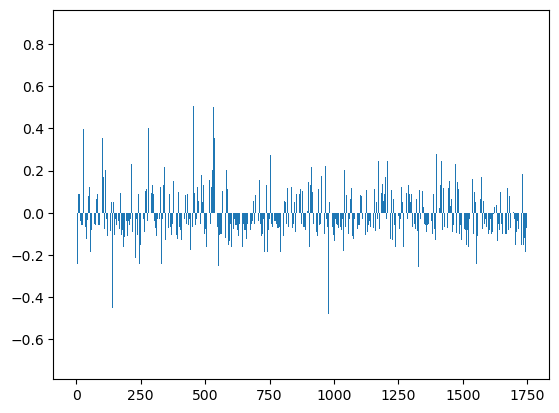

In [163]:
# 긍정적이라고 판단되는 단어도 있고 부정이라고 판단되는 단어도 있음 
plt.figure()

plt.bar(range(len(logi.coef_.flatten())), logi.coef_.flatten())
plt.show()

In [164]:
# 회귀 모델의 계수를 내림차순으로 정렬
# 기울 기값을 value 받고
# value 튜플에 넣음 
coef_pos_idx = sorted(((value, idx) for idx, value in enumerate(logi.coef_.flatten())),
                      reverse = True)

In [165]:
# 0. : 긍정 / -0. : 부정
coef_pos_idx

[(0.8834016478196872, 540),
 (0.5588407367882885, 1389),
 (0.5048189814773009, 455),
 (0.5038602931466214, 533),
 (0.47805416708804593, 1416),
 (0.42486187079733123, 549),
 (0.40769664150959667, 1083),
 (0.4005278181356543, 281),
 (0.39707639765035324, 29),
 (0.3748298880409871, 472),
 (0.36103782667374085, 311),
 (0.3570663677333, 537),
 (0.3531825071112877, 102),
 (0.3531048335176378, 632),
 (0.315852598904479, 1400),
 (0.2974552734418218, 1535),
 (0.2944835702370498, 539),
 (0.2832159362575733, 1742),
 (0.2832159362575733, 1636),
 (0.2832159362575733, 1529),
 (0.2832159362575733, 1528),
 (0.2832159362575733, 1212),
 (0.2832159362575733, 735),
 (0.28114820149673564, 1396),
 (0.279761156647255, 450),
 (0.2771060727352423, 1398),
 (0.273384922256039, 754),
 (0.26759545321558503, 807),
 (0.2617423063469723, 543),
 (0.2575231953049453, 1216),
 (0.25637635942976483, 92),
 (0.2496284189436735, 957),
 (0.2496284189436735, 27),
 (0.2470854006501756, 1417),
 (0.24619595764823282, 1208),
 (0.2

In [166]:
# 상위 20개 긍정 형태소
# for value :기울기값, 몇번 idx 인지 
for value, idx in coef_pos_idx[:20]:
    print(tfidf.get_feature_names_out()[idx], value)

맛있어요 0.8834016478196872
조금 0.5588407367882885
라자냐 0.5048189814773009
맛있고 0.5038602931466214
좋아요 0.47805416708804593
맛있음 0.42486187079733123
양이 0.40769664150959667
노포의 0.4005278181356543
가성비 0.39707639765035324
마늘바게트 0.3748298880409871
다른 0.36103782667374085
맛있다 0.3570663677333
고등어 0.3531825071112877
무조건 0.3531048335176378
졸라 0.315852598904479
추억의 0.2974552734418218
맛있습니다 0.2944835702370498
흑흑 0.2832159362575733
평양냉면 0.2832159362575733
최고예요 0.2832159362575733


In [167]:
# 상위 20개 부정 형태소
# 돈까스가 들어간곳에 어떤 부정적인 문장인지 시간날때 확인하기 
for value, idx in coef_pos_idx[:-20:-1]:
    print(tfidf.get_feature_names_out()[idx], value)

별로 -0.7093833950457102
그냥 -0.6600355261288586
아까움 -0.4777762893418217
하나도 -0.4777762893418217
불친절합니다 -0.4509209762746244
굳이 -0.4495884551037068
가격이 -0.43802691730609067
계좌이체 -0.42054948034908973
카드 -0.42054948034908973
주문 -0.34132865832316994
파이 -0.339680464421844
엄청 -0.3170442760600387
그리고 -0.31417156089712295
한식집같아요 -0.30145155103594057
올라서 -0.29054155092118455
가성비꽝 -0.28396618969318055
광고 -0.28396618969318055
괜찮은집 -0.28396618969318055
다시는안간다 -0.28396618969318055
